In [1]:
from paths import DATA_DIR, CKPT_FOLDER, PROJECT_FOLDER

import matplotlib.pyplot as plt
import numpy as np
import torch
import scanpy as sc
import scvelo as scv
import cellrank as cr

import scipy
import anndata
import pandas as pd
import seaborn as sns
from torchdyn.core import NeuralODE

from scCFM.datamodules.time_sc_datamodule import TrajectoryDataModule
from scCFM.models.cfm.components.mlp import MLP
from scCFM.models.cfm.cfm_module import CFMLitModule
from scCFM.models.base.vae import VAE
from scCFM.models.base.geometric_vae import GeometricNBVAE
from scCFM.datamodules.sc_datamodule import scDataModule
from scCFM.models.cfm.components.eval.distribution_distances import compute_distribution_distances

I0000 00:00:1701447712.917473 3093388 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
def get_gene_ids(adata, gene_names):
    """
    Starting from cells of a certain cell type, we trace back to previous time points 
    """
    # Collect indices of genes of interest
    gene_to_id = {}
    gene_list = list(adata.var.gene_name)
    for gene in gene_names:
        gene_to_id[gene] = gene_list.index(gene)
    return gene_to_id

def plot_violin_condition(anndata_list, gene_name, idx, methods):
    """
    Cell types on the x axis and gene expression on the y-axis
    """
    # Extract Leiden cluster assignments from each anndata object
    leiden_clusters = [adata.obs['leiden'] for adata in anndata_list]
    
    # Extract gene expression data
    gene_expression = []
    for adata in anndata_list:
        try:
            gene_expression.append(adata[:, idx].X.ravel())
        except:
            gene_expression.append(adata[:, idx].X.A.ravel())
    
    # Method names
    methods_names = []
    for i, method_name in enumerate(methods):
        methods_names += [method_name for _ in range(len(gene_expression[i]))]
    
    # Concatenate data
    leiden_clusters = np.concatenate(leiden_clusters)
    gene_expression = np.concatenate(gene_expression)
    method = np.array(methods_names)
    
    # Create a violin plot
    plt.figure(figsize=(8, 3))
    plotting_dict = {"gene_expression": gene_expression, 
                     "leiden_clusters": leiden_clusters,
                     "method": method}
 
    plotting_dict["leiden_clusters"] = [CLUSTER_ANNOTATIONS[i] for i in plotting_dict["leiden_clusters"]]
    
    ax = sns.violinplot(x="leiden_clusters", y="gene_expression", hue="method", data=plotting_dict,
                whis=[40, 60], width=0.8, palette="vlag", showfliers=False, hue_order=["scTour", "FlatVI", "Real"])
    # ax = sns.barplot(x="leiden_clusters", y="gene_expression", hue="method", data=plotting_dict,
    #             palette="colorblind", hue_order=["NB-VAE", "Flat NB-VAE", "Real"])

    # Add in points to show each observation
    sns.stripplot(x="leiden_clusters", y="gene_expression", hue="method", data=plotting_dict,
                  size=4, color=".3", linewidth=0, dodge=0.2, legend=False)

    plt.ylabel("log(GEX)")
    plt.xlabel("cell type")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(gene_name)
    plt.show()

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
CLUSTER_ANNOTATIONS = {"7": "ESC",
                      "4": "NE-1",
                      "8": "NE-2",
                      "1": "NP",
                      "10": "NS",
                      "3": "NC",
                      "12": "NS-3",
                      "9": "EC-1",
                      "11": "H",
                      "2": "SMP",
                      "0": "LP-ME",
                      "5": "CP", 
                      "13": "PRE-NE",
                      "6": "EN"
                     }

## Util functions

In [5]:
adata_simulated_flatvi = sc.read_h5ad("/lustre/groups/ml01/workspace/alessandro.palma/scCFM/rebuttals/scTour/generated_counts_flatvi.h5ad")
adata_simulated_sctour = sc.read_h5ad("/lustre/groups/ml01/workspace/alessandro.palma/scCFM/rebuttals/scTour/generated_counts.h5ad")
adata_eb_original = sc.read_h5ad('/lustre/groups/ml01/workspace/alessandro.palma/scCFM/data/eb/processed/eb_phate.h5ad')

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Finish sctour output preprocessing

In [6]:
sc.pp.log1p(adata_simulated_sctour)
sc.tl.pca(adata_simulated_sctour)
sc.pp.neighbors(adata_simulated_sctour)
sc.tl.umap(adata_simulated_sctour)

In [7]:
adata_simulated_sctour.var = adata_eb_original.var

In [8]:
sc.tl.ingest(adata_simulated_sctour, adata_eb_original, obs="leiden", embedding_method="umap")

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


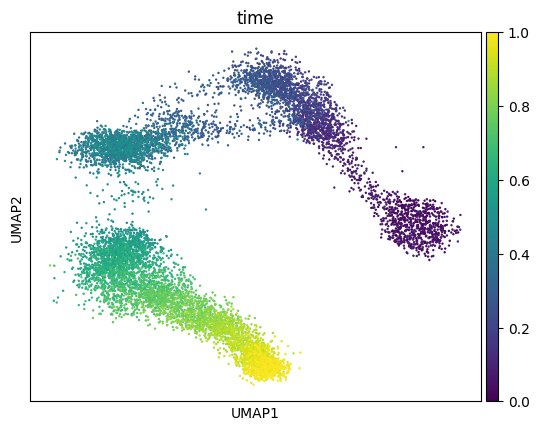

In [9]:
sc.pl.umap(adata_simulated_sctour, color="time")

In [10]:
adata_simulated_sctour

AnnData object with n_obs × n_vars = 10100 × 1241
    obs: 'time', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_name', 'gene_id', 'gene_name_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'pca', 'umap', 'log1p'
    obsm: 'X_pca', 'X_umap', 'rep'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# Analysis

Initialize datamodule

**Decoded trajectories**

# Perform lineage analysis

### Neural crest

In [11]:
adata_flatvi_neural_crests = adata_simulated_flatvi[adata_simulated_flatvi.obs.leiden.isin(['7', '4', '8', '3'])]
adata_simulated_sctour_neural_crests = adata_simulated_sctour[adata_simulated_sctour.obs.leiden.isin(['7', '4', '8', '3'])]
adata_eb_original_neural_crest = adata_eb_original[adata_eb_original.obs.leiden.isin(['7', '4', '8', '3'])]

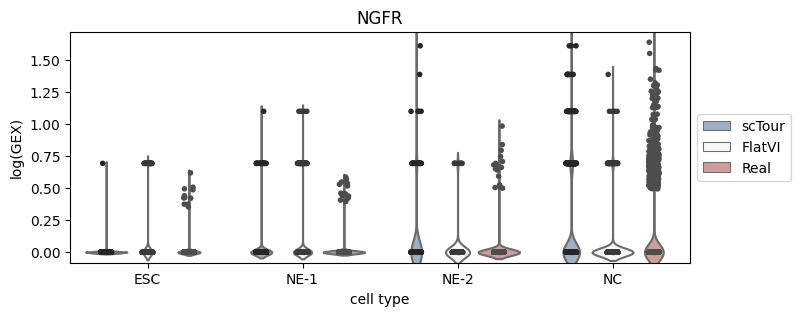

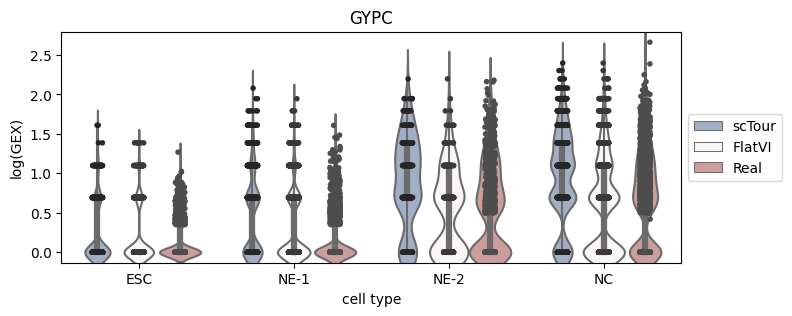

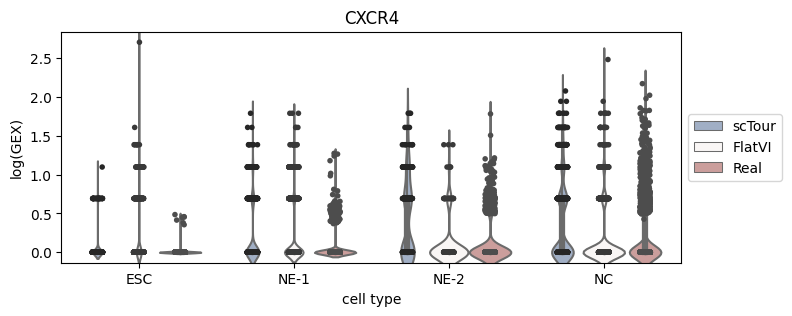

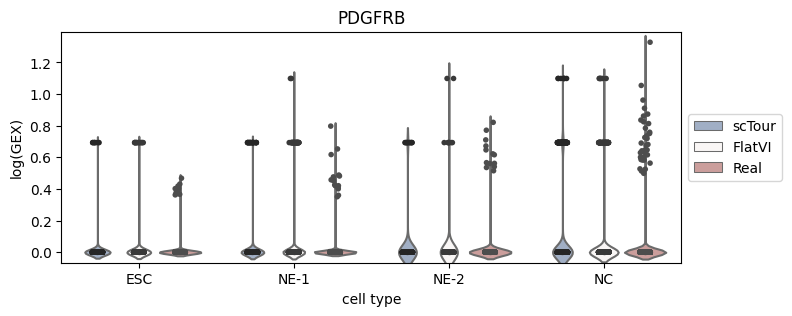

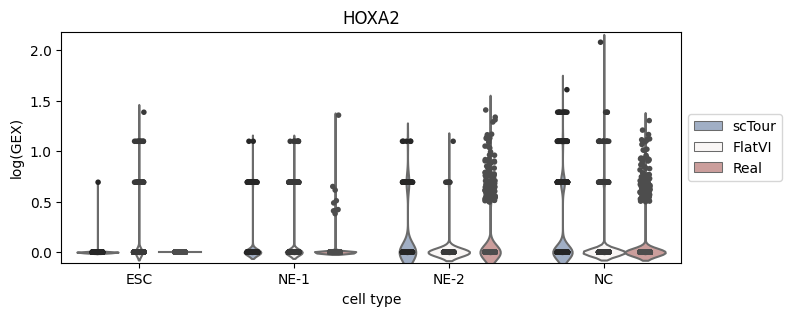

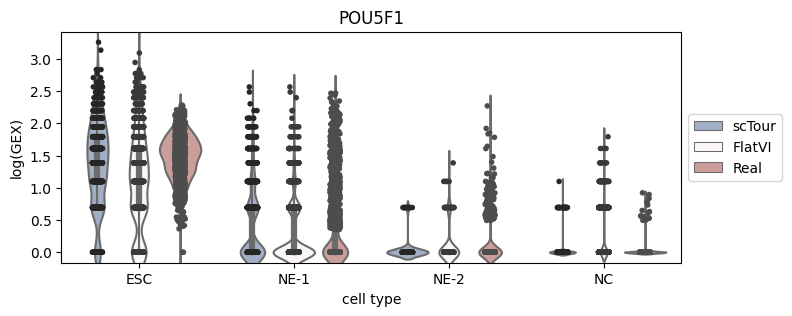

In [12]:
genes_neural_crest_cells = ["NGFR", "GYPC", "CXCR4", "PDGFRB", "HOXA2", "POU5F1"]
get_gene_ids_neural_crests = get_gene_ids(adata_eb_original_neural_crest, genes_neural_crest_cells)

for gene, gene_id in get_gene_ids_neural_crests.items():
    plot_violin_condition([adata_simulated_sctour_neural_crests, adata_flatvi_neural_crests, adata_eb_original_neural_crest],
                            gene, 
                            gene_id,
                            methods= ["scTour", "FlatVI","Real"])

In [33]:
dist_sctour_neural_crest = 0 
dist_flatvi_neural_crest = 0
for marker_id in get_gene_ids_neural_crests.values():
    dist_flatvi_neural_crest += scipy.stats.wasserstein_distance(np.array(adata_flatvi_neural_crests[:, marker_id].X).squeeze(), 
                   np.array(adata_eb_original_neural_crest[:, marker_id].X.A).squeeze())
    dist_sctour_neural_crest += scipy.stats.wasserstein_distance(np.array(adata_simulated_sctour_neural_crests[:, marker_id].X).squeeze(), 
                   np.array(adata_eb_original_neural_crest[:, marker_id].X.A).squeeze())

In [34]:
dist_sctour_neural_crest/6

0.07332150184994933

In [35]:
dist_flatvi_neural_crest/6

0.038576351066415875

### Neuronal

In [18]:
adata_flatvi_neuronal = adata_simulated_flatvi[adata_simulated_flatvi.obs.leiden.isin(['7', '4', '1', '10'])]
adata_simulated_sctour_neuronal = adata_simulated_sctour[adata_simulated_sctour.obs.leiden.isin(['7', '4', '1', '10'])]
adata_eb_original_neuronal = adata_eb_original[adata_eb_original.obs.leiden.isin(['7', '4', '1', '10'])]

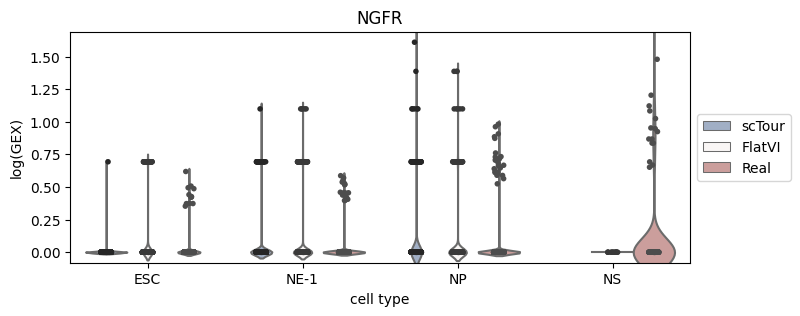

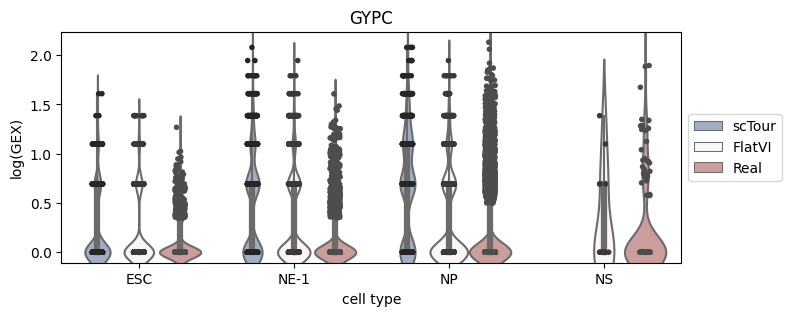

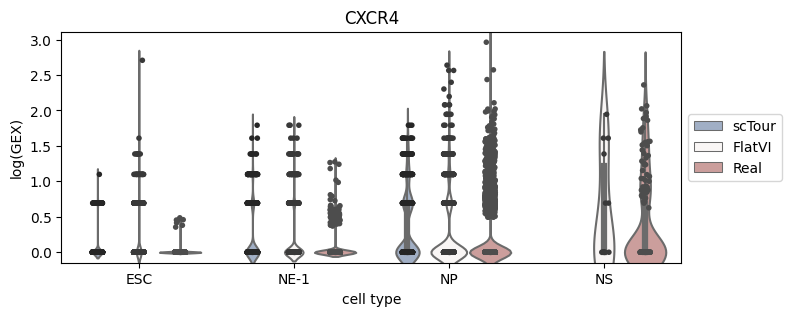

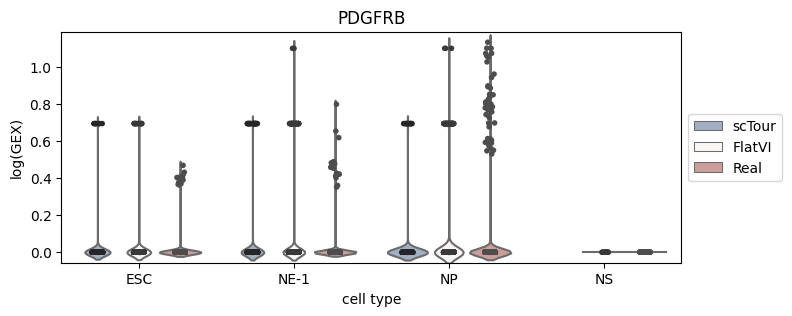

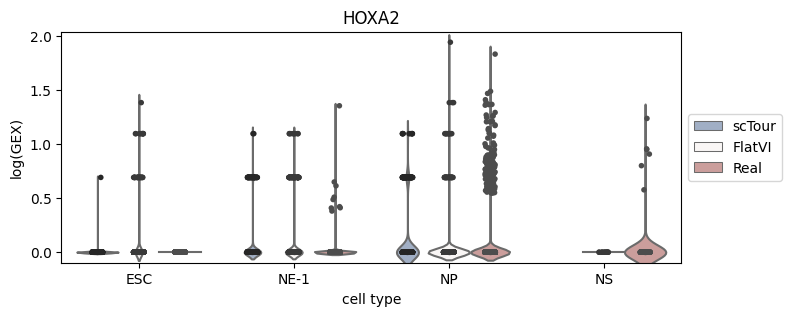

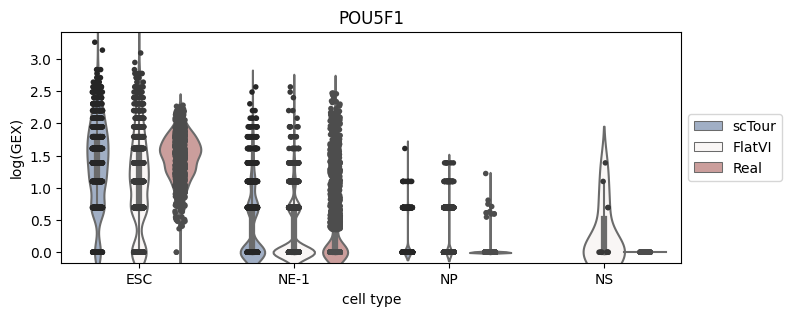

In [19]:
genes_neuronal = ["LMX1A", "ISL1", "DLX1", "CXCR4", "HOXB1", "NR2F1"]
get_gene_ids_neuronal = get_gene_ids(adata_eb_original_neuronal, genes_neuronal)

for gene, gene_id in get_gene_ids_neural_crests.items():
    plot_violin_condition([adata_simulated_sctour_neuronal, adata_flatvi_neuronal, adata_eb_original_neuronal],
                            gene, 
                            gene_id,
                            methods= ["scTour", "FlatVI","Real"])

In [20]:
dist_sctour_neuronal = 0 
dist_flatvi_neuronal = 0
for marker_id in get_gene_ids_neuronal.values():
    dist_flatvi_neuronal += scipy.stats.wasserstein_distance(np.array(adata_flatvi_neuronal[:, marker_id].X).squeeze(), 
                   np.array(adata_eb_original_neural_crest[:, marker_id].X.A).squeeze())
    dist_sctour_neuronal += scipy.stats.wasserstein_distance(np.array(adata_simulated_sctour_neuronal[:, marker_id].X).squeeze(), 
                   np.array(adata_eb_original_neuronal[:, marker_id].X.A).squeeze())

In [21]:
dist_flatvi_neuronal/6

0.016643788116670402

In [22]:
dist_sctour_neuronal/6

0.028317406615390533

### Cardiac

In [23]:
adata_flatvi_cardiac = adata_simulated_flatvi[adata_simulated_flatvi.obs.leiden.isin(['7', '9', '2', '5'])]
adata_simulated_sctour_cardiac = adata_simulated_sctour[adata_simulated_sctour.obs.leiden.isin(['7', '9', '2', '5'])]
adata_eb_original_cardiac = adata_eb_original[adata_eb_original.obs.leiden.isin(['7', '9', '2', '5'])]

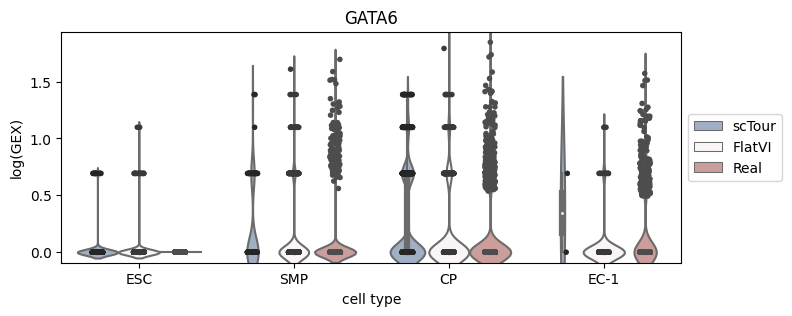

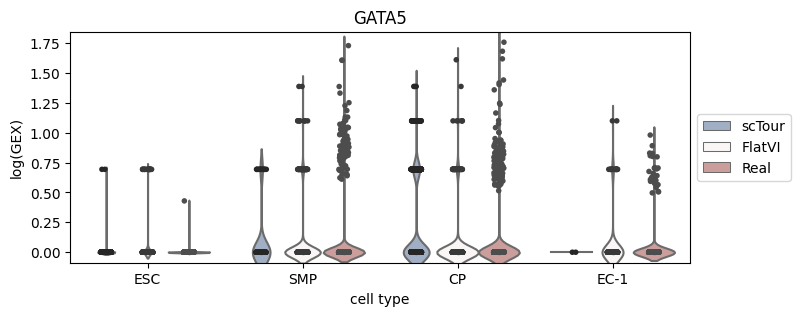

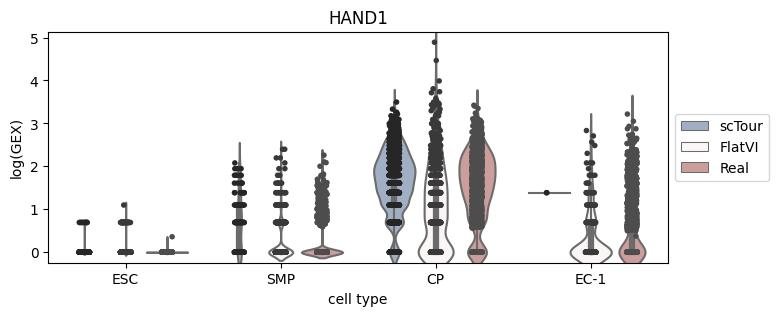

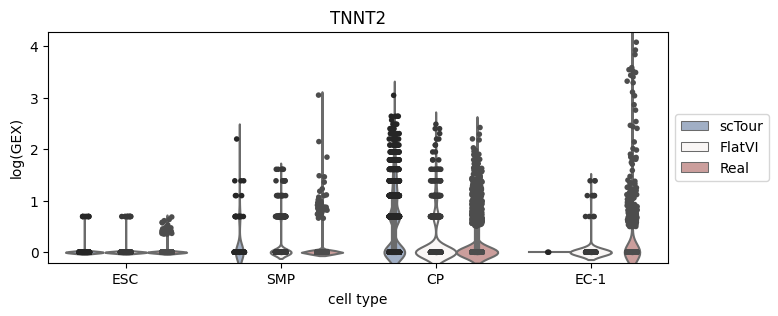

In [24]:
genes_cardiac = ["GATA6", "GATA5", "HAND1", "TNNT2"]
get_gene_ids_cardiac = get_gene_ids(adata_eb_original_cardiac, genes_cardiac)

for gene, gene_id in get_gene_ids_cardiac.items():
    plot_violin_condition([adata_simulated_sctour_cardiac, adata_flatvi_cardiac, adata_eb_original_cardiac],
                            gene, 
                            gene_id,
                            methods= ["scTour", "FlatVI","Real"])

In [36]:
dist_sctour_cardiac = 0 
dist_flatvi_cardiac = 0
for marker_id in get_gene_ids_cardiac.values():
    dist_flatvi_cardiac += scipy.stats.wasserstein_distance(np.array(adata_flatvi_cardiac[:, marker_id].X).squeeze(), 
                   np.array(adata_eb_original_cardiac[:, marker_id].X.A).squeeze())
    dist_sctour_cardiac += scipy.stats.wasserstein_distance(np.array(adata_simulated_sctour_cardiac[:, marker_id].X).squeeze(), 
                   np.array(adata_eb_original_cardiac[:, marker_id].X.A).squeeze())

In [37]:
dist_sctour_cardiac /4 

0.2782520349970225

In [38]:
dist_flatvi_cardiac /4 

0.06920735291003807

## Endoderm

In [39]:
adata_flatvi_endoderm = adata_simulated_flatvi[adata_simulated_flatvi.obs.leiden.isin(['7', '13', '4', '6'])]
adata_simulated_sctour_endoderm = adata_simulated_sctour[adata_simulated_sctour.obs.leiden.isin(['7', '13', '4', '6'])]
adata_eb_original_endoderm = adata_eb_original[adata_eb_original.obs.leiden.isin(['7', '13', '4', '6'])]

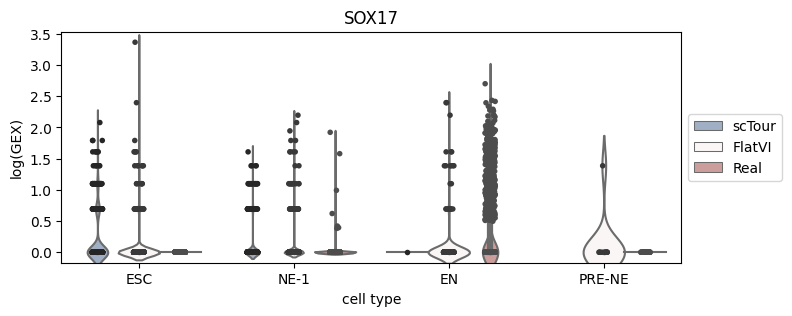

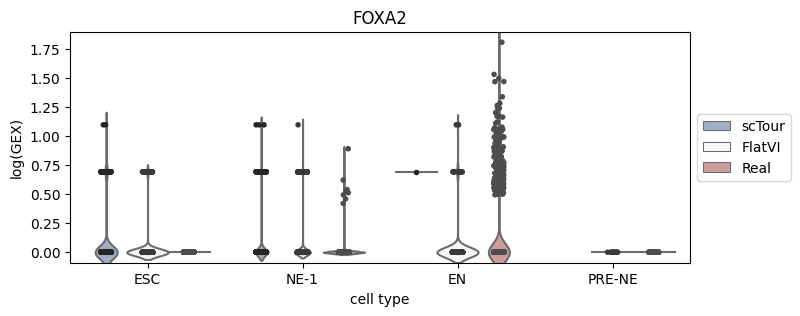

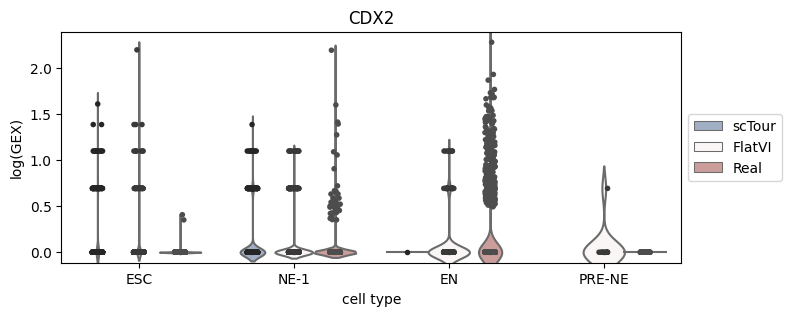

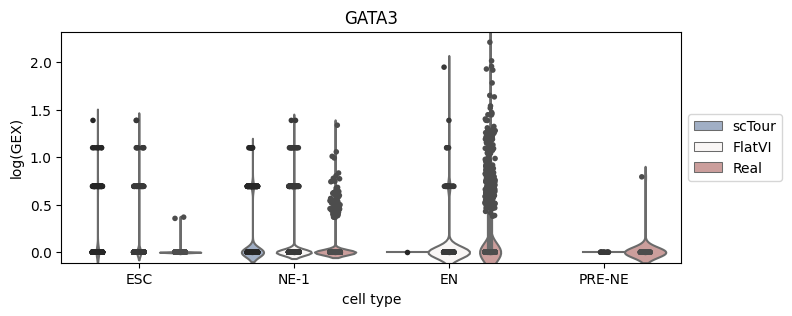

In [40]:
genes_endoderm = ["SOX17", "FOXA2", "CDX2", "GATA3"]
get_gene_ids_endoderm = get_gene_ids(adata_eb_original_endoderm, genes_endoderm)

for gene, gene_id in get_gene_ids_endoderm.items():
    plot_violin_condition([adata_simulated_sctour_endoderm, adata_flatvi_endoderm, adata_eb_original_endoderm],
                            gene, 
                            gene_id,
                            methods= ["scTour", "FlatVI","Real"])

In [41]:
dist_sctour_endoderm = 0 
dist_flatvi_endoderm = 0
for marker_id in get_gene_ids_endoderm.values():
    dist_flatvi_endoderm += scipy.stats.wasserstein_distance(np.array(adata_flatvi_endoderm[:, marker_id].X).squeeze(), 
                   np.array(adata_eb_original_endoderm[:, marker_id].X.A).squeeze())
    dist_sctour_endoderm += scipy.stats.wasserstein_distance(np.array(adata_simulated_sctour_endoderm[:, marker_id].X).squeeze(), 
                   np.array(adata_eb_original_endoderm[:, marker_id].X.A).squeeze())

In [42]:
dist_sctour_endoderm / 4

0.027039731525721332

In [43]:
dist_flatvi_endoderm / 4

0.04526092634816065